In [1]:
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR

In [9]:
# Check for GPU
device = torch.device('cpu')
print("Running on ", device, " cores")

# Load the data
FirstData = np.load("fullsky4catsgaia.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
ypostencode = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

# Calculate class weights
class_counts = np.bincount(np.argmax(ypostencode, axis=1))
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer, schedular for learning rate
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Check for GPU
model.to(device)  # Moves the model to the GPU

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(y_batch.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training the model with a loading bar
epochs = 400
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm for a loading bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)
    
    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'\nTest Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')
    if test_accuracy > 0.97:
        break
torch.save(model.state_dict(), "star_classifier_Exp2.pth") # Save the model

Running on  cpu  cores


Epoch 1/400: 100%|██████████| 142/142 [00:00<00:00, 173.43batch/s, Loss=4.4556]



Test Accuracy after Epoch 1: 0.8591


Epoch 2/400: 100%|██████████| 142/142 [00:00<00:00, 190.04batch/s, Loss=3.5744]



Test Accuracy after Epoch 2: 0.8694


Epoch 3/400: 100%|██████████| 142/142 [00:00<00:00, 174.97batch/s, Loss=3.5271]



Test Accuracy after Epoch 3: 0.8660


Epoch 4/400: 100%|██████████| 142/142 [00:00<00:00, 185.01batch/s, Loss=3.5126]



Test Accuracy after Epoch 4: 0.8568


Epoch 5/400: 100%|██████████| 142/142 [00:00<00:00, 144.25batch/s, Loss=3.4825]



Test Accuracy after Epoch 5: 0.8916


Epoch 6/400: 100%|██████████| 142/142 [00:00<00:00, 180.38batch/s, Loss=3.4595]



Test Accuracy after Epoch 6: 0.9118


Epoch 7/400: 100%|██████████| 142/142 [00:00<00:00, 173.56batch/s, Loss=3.4559]



Test Accuracy after Epoch 7: 0.9255


Epoch 8/400: 100%|██████████| 142/142 [00:00<00:00, 171.18batch/s, Loss=3.4498]



Test Accuracy after Epoch 8: 0.9370


Epoch 9/400: 100%|██████████| 142/142 [00:00<00:00, 163.55batch/s, Loss=3.4357]



Test Accuracy after Epoch 9: 0.9339


Epoch 10/400: 100%|██████████| 142/142 [00:00<00:00, 188.45batch/s, Loss=3.4314]



Test Accuracy after Epoch 10: 0.9388


Epoch 11/400: 100%|██████████| 142/142 [00:00<00:00, 162.17batch/s, Loss=3.4162]



Test Accuracy after Epoch 11: 0.9360


Epoch 12/400: 100%|██████████| 142/142 [00:00<00:00, 183.58batch/s, Loss=3.4067]



Test Accuracy after Epoch 12: 0.9291


Epoch 13/400: 100%|██████████| 142/142 [00:01<00:00, 132.08batch/s, Loss=3.4203]



Test Accuracy after Epoch 13: 0.9110


Epoch 14/400: 100%|██████████| 142/142 [00:00<00:00, 168.76batch/s, Loss=3.4206]



Test Accuracy after Epoch 14: 0.9314


Epoch 15/400: 100%|██████████| 142/142 [00:00<00:00, 166.81batch/s, Loss=3.4051]



Test Accuracy after Epoch 15: 0.9435


Epoch 16/400: 100%|██████████| 142/142 [00:00<00:00, 155.86batch/s, Loss=3.4042]



Test Accuracy after Epoch 16: 0.9062


Epoch 17/400: 100%|██████████| 142/142 [00:01<00:00, 133.58batch/s, Loss=3.4123]



Test Accuracy after Epoch 17: 0.8899


Epoch 18/400: 100%|██████████| 142/142 [00:00<00:00, 164.58batch/s, Loss=3.4213]



Test Accuracy after Epoch 18: 0.9454


Epoch 19/400: 100%|██████████| 142/142 [00:00<00:00, 158.96batch/s, Loss=3.3913]



Test Accuracy after Epoch 19: 0.9226


Epoch 20/400: 100%|██████████| 142/142 [00:00<00:00, 180.16batch/s, Loss=3.4004]



Test Accuracy after Epoch 20: 0.9376


Epoch 21/400: 100%|██████████| 142/142 [00:01<00:00, 121.55batch/s, Loss=3.3904]



Test Accuracy after Epoch 21: 0.9363


Epoch 22/400: 100%|██████████| 142/142 [00:00<00:00, 143.95batch/s, Loss=3.3664]



Test Accuracy after Epoch 22: 0.9300


Epoch 23/400: 100%|██████████| 142/142 [00:00<00:00, 157.87batch/s, Loss=3.3817]



Test Accuracy after Epoch 23: 0.9431


Epoch 24/400: 100%|██████████| 142/142 [00:00<00:00, 147.33batch/s, Loss=3.4088]



Test Accuracy after Epoch 24: 0.7581


Epoch 25/400: 100%|██████████| 142/142 [00:00<00:00, 149.32batch/s, Loss=3.4201]



Test Accuracy after Epoch 25: 0.9366


Epoch 26/400: 100%|██████████| 142/142 [00:00<00:00, 142.32batch/s, Loss=3.3827]



Test Accuracy after Epoch 26: 0.9415


Epoch 27/400: 100%|██████████| 142/142 [00:00<00:00, 157.61batch/s, Loss=3.3877]



Test Accuracy after Epoch 27: 0.9389


Epoch 28/400: 100%|██████████| 142/142 [00:00<00:00, 157.43batch/s, Loss=3.3709]



Test Accuracy after Epoch 28: 0.9574


Epoch 29/400: 100%|██████████| 142/142 [00:01<00:00, 133.11batch/s, Loss=3.3617]



Test Accuracy after Epoch 29: 0.9454


Epoch 30/400: 100%|██████████| 142/142 [00:00<00:00, 150.11batch/s, Loss=3.3712]



Test Accuracy after Epoch 30: 0.9398


Epoch 31/400: 100%|██████████| 142/142 [00:00<00:00, 157.86batch/s, Loss=3.3601]



Test Accuracy after Epoch 31: 0.9496


Epoch 32/400: 100%|██████████| 142/142 [00:00<00:00, 149.55batch/s, Loss=3.3919]



Test Accuracy after Epoch 32: 0.9502


Epoch 33/400: 100%|██████████| 142/142 [00:00<00:00, 167.87batch/s, Loss=3.3822]



Test Accuracy after Epoch 33: 0.9382


Epoch 34/400: 100%|██████████| 142/142 [00:00<00:00, 152.23batch/s, Loss=3.3715]



Test Accuracy after Epoch 34: 0.9444


Epoch 35/400: 100%|██████████| 142/142 [00:00<00:00, 158.24batch/s, Loss=3.3677]



Test Accuracy after Epoch 35: 0.9050


Epoch 36/400: 100%|██████████| 142/142 [00:00<00:00, 143.31batch/s, Loss=3.3591]



Test Accuracy after Epoch 36: 0.9396


Epoch 37/400: 100%|██████████| 142/142 [00:00<00:00, 150.58batch/s, Loss=3.4219]



Test Accuracy after Epoch 37: 0.9445


Epoch 38/400: 100%|██████████| 142/142 [00:00<00:00, 150.73batch/s, Loss=3.3481]



Test Accuracy after Epoch 38: 0.9381


Epoch 39/400: 100%|██████████| 142/142 [00:00<00:00, 165.55batch/s, Loss=3.3544]



Test Accuracy after Epoch 39: 0.9480


Epoch 40/400: 100%|██████████| 142/142 [00:00<00:00, 147.50batch/s, Loss=3.3421]



Test Accuracy after Epoch 40: 0.9500


Epoch 41/400: 100%|██████████| 142/142 [00:00<00:00, 158.51batch/s, Loss=3.3547]



Test Accuracy after Epoch 41: 0.9568


Epoch 42/400: 100%|██████████| 142/142 [00:00<00:00, 158.16batch/s, Loss=3.3520]



Test Accuracy after Epoch 42: 0.9548


Epoch 43/400: 100%|██████████| 142/142 [00:00<00:00, 156.41batch/s, Loss=3.3631]



Test Accuracy after Epoch 43: 0.9510


Epoch 44/400: 100%|██████████| 142/142 [00:00<00:00, 161.34batch/s, Loss=3.3654]



Test Accuracy after Epoch 44: 0.9425


Epoch 45/400: 100%|██████████| 142/142 [00:00<00:00, 158.74batch/s, Loss=3.3684]



Test Accuracy after Epoch 45: 0.9485


Epoch 46/400: 100%|██████████| 142/142 [00:00<00:00, 151.82batch/s, Loss=3.3413]



Test Accuracy after Epoch 46: 0.9410


Epoch 47/400: 100%|██████████| 142/142 [00:00<00:00, 144.60batch/s, Loss=3.3513]



Test Accuracy after Epoch 47: 0.9465


Epoch 48/400: 100%|██████████| 142/142 [00:00<00:00, 148.84batch/s, Loss=3.3697]



Test Accuracy after Epoch 48: 0.8743


Epoch 49/400: 100%|██████████| 142/142 [00:00<00:00, 151.33batch/s, Loss=3.3795]



Test Accuracy after Epoch 49: 0.9331


Epoch 50/400: 100%|██████████| 142/142 [00:00<00:00, 167.04batch/s, Loss=3.3664]



Test Accuracy after Epoch 50: 0.9407


Epoch 51/400: 100%|██████████| 142/142 [00:01<00:00, 137.24batch/s, Loss=3.3498]



Test Accuracy after Epoch 51: 0.9404


Epoch 52/400: 100%|██████████| 142/142 [00:01<00:00, 121.36batch/s, Loss=3.3516]



Test Accuracy after Epoch 52: 0.9587


Epoch 53/400: 100%|██████████| 142/142 [00:00<00:00, 153.85batch/s, Loss=3.3425]



Test Accuracy after Epoch 53: 0.9584


Epoch 54/400: 100%|██████████| 142/142 [00:00<00:00, 161.76batch/s, Loss=3.3843]



Test Accuracy after Epoch 54: 0.9261


Epoch 55/400: 100%|██████████| 142/142 [00:00<00:00, 161.00batch/s, Loss=3.3417]



Test Accuracy after Epoch 55: 0.9594


Epoch 56/400: 100%|██████████| 142/142 [00:00<00:00, 153.66batch/s, Loss=3.3301]



Test Accuracy after Epoch 56: 0.9541


Epoch 57/400: 100%|██████████| 142/142 [00:01<00:00, 140.34batch/s, Loss=3.3524]



Test Accuracy after Epoch 57: 0.9613


Epoch 58/400: 100%|██████████| 142/142 [00:00<00:00, 145.92batch/s, Loss=3.3511]



Test Accuracy after Epoch 58: 0.9516


Epoch 59/400: 100%|██████████| 142/142 [00:00<00:00, 171.98batch/s, Loss=3.3409]



Test Accuracy after Epoch 59: 0.9567


Epoch 60/400: 100%|██████████| 142/142 [00:01<00:00, 131.11batch/s, Loss=3.3553]



Test Accuracy after Epoch 60: 0.9469


Epoch 61/400: 100%|██████████| 142/142 [00:00<00:00, 155.92batch/s, Loss=3.3453]



Test Accuracy after Epoch 61: 0.9582


Epoch 62/400: 100%|██████████| 142/142 [00:00<00:00, 157.93batch/s, Loss=3.3837]



Test Accuracy after Epoch 62: 0.9040


Epoch 63/400: 100%|██████████| 142/142 [00:00<00:00, 163.60batch/s, Loss=3.3717]



Test Accuracy after Epoch 63: 0.9258


Epoch 64/400: 100%|██████████| 142/142 [00:00<00:00, 154.87batch/s, Loss=3.3673]



Test Accuracy after Epoch 64: 0.9138


Epoch 65/400: 100%|██████████| 142/142 [00:00<00:00, 168.87batch/s, Loss=3.3382]



Test Accuracy after Epoch 65: 0.9409


Epoch 66/400: 100%|██████████| 142/142 [00:00<00:00, 159.45batch/s, Loss=3.3326]



Test Accuracy after Epoch 66: 0.9380


Epoch 67/400: 100%|██████████| 142/142 [00:00<00:00, 162.00batch/s, Loss=3.3347]



Test Accuracy after Epoch 67: 0.9558


Epoch 68/400: 100%|██████████| 142/142 [00:01<00:00, 135.53batch/s, Loss=3.3383]



Test Accuracy after Epoch 68: 0.9351


Epoch 69/400: 100%|██████████| 142/142 [00:00<00:00, 166.27batch/s, Loss=3.3294]



Test Accuracy after Epoch 69: 0.9540


Epoch 70/400: 100%|██████████| 142/142 [00:00<00:00, 163.14batch/s, Loss=3.3141]



Test Accuracy after Epoch 70: 0.9569


Epoch 71/400: 100%|██████████| 142/142 [00:00<00:00, 158.99batch/s, Loss=3.3309]



Test Accuracy after Epoch 71: 0.9497


Epoch 72/400: 100%|██████████| 142/142 [00:00<00:00, 158.58batch/s, Loss=3.3369]



Test Accuracy after Epoch 72: 0.9513


Epoch 73/400: 100%|██████████| 142/142 [00:00<00:00, 173.08batch/s, Loss=3.3113]



Test Accuracy after Epoch 73: 0.9587


Epoch 74/400: 100%|██████████| 142/142 [00:00<00:00, 155.57batch/s, Loss=3.3212]



Test Accuracy after Epoch 74: 0.9478


Epoch 75/400: 100%|██████████| 142/142 [00:00<00:00, 170.09batch/s, Loss=3.3201]



Test Accuracy after Epoch 75: 0.9447


Epoch 76/400: 100%|██████████| 142/142 [00:01<00:00, 138.84batch/s, Loss=3.3197]



Test Accuracy after Epoch 76: 0.9521


Epoch 77/400: 100%|██████████| 142/142 [00:00<00:00, 151.94batch/s, Loss=3.3091]



Test Accuracy after Epoch 77: 0.9591


Epoch 78/400: 100%|██████████| 142/142 [00:00<00:00, 157.28batch/s, Loss=3.3464]



Test Accuracy after Epoch 78: 0.9469


Epoch 79/400: 100%|██████████| 142/142 [00:00<00:00, 167.30batch/s, Loss=3.3188]



Test Accuracy after Epoch 79: 0.9517


Epoch 80/400: 100%|██████████| 142/142 [00:00<00:00, 160.70batch/s, Loss=3.3257]



Test Accuracy after Epoch 80: 0.9445


Epoch 81/400: 100%|██████████| 142/142 [00:00<00:00, 151.19batch/s, Loss=3.3284]



Test Accuracy after Epoch 81: 0.9589


Epoch 82/400: 100%|██████████| 142/142 [00:00<00:00, 154.18batch/s, Loss=3.3325]



Test Accuracy after Epoch 82: 0.9507


Epoch 83/400: 100%|██████████| 142/142 [00:01<00:00, 137.93batch/s, Loss=3.3144]



Test Accuracy after Epoch 83: 0.9442


Epoch 84/400: 100%|██████████| 142/142 [00:00<00:00, 166.48batch/s, Loss=3.3114]



Test Accuracy after Epoch 84: 0.9502


Epoch 85/400: 100%|██████████| 142/142 [00:00<00:00, 161.58batch/s, Loss=3.3272]



Test Accuracy after Epoch 85: 0.9514


Epoch 86/400: 100%|██████████| 142/142 [00:00<00:00, 156.16batch/s, Loss=3.4541]



Test Accuracy after Epoch 86: 0.9481


Epoch 87/400: 100%|██████████| 142/142 [00:00<00:00, 161.95batch/s, Loss=3.3647]



Test Accuracy after Epoch 87: 0.9452


Epoch 88/400: 100%|██████████| 142/142 [00:00<00:00, 161.68batch/s, Loss=3.3527]



Test Accuracy after Epoch 88: 0.9062


Epoch 89/400: 100%|██████████| 142/142 [00:00<00:00, 142.56batch/s, Loss=3.3500]



Test Accuracy after Epoch 89: 0.9073


Epoch 90/400: 100%|██████████| 142/142 [00:00<00:00, 163.18batch/s, Loss=3.3543]



Test Accuracy after Epoch 90: 0.9298


Epoch 91/400: 100%|██████████| 142/142 [00:01<00:00, 129.32batch/s, Loss=3.3338]



Test Accuracy after Epoch 91: 0.9300


Epoch 92/400: 100%|██████████| 142/142 [00:01<00:00, 141.68batch/s, Loss=3.3256]



Test Accuracy after Epoch 92: 0.9437


Epoch 93/400: 100%|██████████| 142/142 [00:00<00:00, 157.06batch/s, Loss=3.3257]



Test Accuracy after Epoch 93: 0.9558


Epoch 94/400: 100%|██████████| 142/142 [00:00<00:00, 168.20batch/s, Loss=3.3178]



Test Accuracy after Epoch 94: 0.9533


Epoch 95/400: 100%|██████████| 142/142 [00:00<00:00, 146.98batch/s, Loss=3.3255]



Test Accuracy after Epoch 95: 0.9590


Epoch 96/400: 100%|██████████| 142/142 [00:00<00:00, 145.53batch/s, Loss=3.3146]



Test Accuracy after Epoch 96: 0.9506


Epoch 97/400: 100%|██████████| 142/142 [00:00<00:00, 158.56batch/s, Loss=3.3156]



Test Accuracy after Epoch 97: 0.9595


Epoch 98/400: 100%|██████████| 142/142 [00:00<00:00, 157.65batch/s, Loss=3.3327]



Test Accuracy after Epoch 98: 0.9583


Epoch 99/400: 100%|██████████| 142/142 [00:01<00:00, 130.27batch/s, Loss=3.3407]



Test Accuracy after Epoch 99: 0.9615


Epoch 100/400: 100%|██████████| 142/142 [00:00<00:00, 150.96batch/s, Loss=3.3345]



Test Accuracy after Epoch 100: 0.9378


Epoch 101/400: 100%|██████████| 142/142 [00:00<00:00, 166.55batch/s, Loss=3.3184]



Test Accuracy after Epoch 101: 0.9561


Epoch 102/400: 100%|██████████| 142/142 [00:00<00:00, 165.55batch/s, Loss=3.3782]



Test Accuracy after Epoch 102: 0.9583


Epoch 103/400: 100%|██████████| 142/142 [00:00<00:00, 158.64batch/s, Loss=3.3353]



Test Accuracy after Epoch 103: 0.9596


Epoch 104/400: 100%|██████████| 142/142 [00:00<00:00, 164.39batch/s, Loss=3.3004]



Test Accuracy after Epoch 104: 0.9606


Epoch 105/400: 100%|██████████| 142/142 [00:00<00:00, 168.73batch/s, Loss=3.3136]



Test Accuracy after Epoch 105: 0.9610


Epoch 106/400: 100%|██████████| 142/142 [00:00<00:00, 155.60batch/s, Loss=3.3068]



Test Accuracy after Epoch 106: 0.9534


Epoch 107/400: 100%|██████████| 142/142 [00:01<00:00, 128.51batch/s, Loss=3.3127]



Test Accuracy after Epoch 107: 0.9641


Epoch 108/400: 100%|██████████| 142/142 [00:00<00:00, 162.09batch/s, Loss=3.3245]



Test Accuracy after Epoch 108: 0.9445


Epoch 109/400: 100%|██████████| 142/142 [00:00<00:00, 166.84batch/s, Loss=3.3362]



Test Accuracy after Epoch 109: 0.9620


Epoch 110/400: 100%|██████████| 142/142 [00:00<00:00, 154.88batch/s, Loss=3.3179]



Test Accuracy after Epoch 110: 0.9503


Epoch 111/400: 100%|██████████| 142/142 [00:01<00:00, 137.22batch/s, Loss=3.2997]



Test Accuracy after Epoch 111: 0.9550


Epoch 112/400: 100%|██████████| 142/142 [00:01<00:00, 133.26batch/s, Loss=3.2907]



Test Accuracy after Epoch 112: 0.9611


Epoch 113/400: 100%|██████████| 142/142 [00:00<00:00, 153.20batch/s, Loss=3.2931]



Test Accuracy after Epoch 113: 0.9443


Epoch 114/400: 100%|██████████| 142/142 [00:00<00:00, 160.67batch/s, Loss=3.2985]



Test Accuracy after Epoch 114: 0.9539


Epoch 115/400: 100%|██████████| 142/142 [00:01<00:00, 140.05batch/s, Loss=3.3047]



Test Accuracy after Epoch 115: 0.9597


Epoch 116/400: 100%|██████████| 142/142 [00:00<00:00, 157.36batch/s, Loss=3.3227]



Test Accuracy after Epoch 116: 0.9628


Epoch 117/400: 100%|██████████| 142/142 [00:00<00:00, 158.15batch/s, Loss=3.3628]



Test Accuracy after Epoch 117: 0.9402


Epoch 118/400: 100%|██████████| 142/142 [00:01<00:00, 133.74batch/s, Loss=3.3349]



Test Accuracy after Epoch 118: 0.9546


Epoch 119/400: 100%|██████████| 142/142 [00:01<00:00, 137.87batch/s, Loss=3.3024]



Test Accuracy after Epoch 119: 0.9557


Epoch 120/400: 100%|██████████| 142/142 [00:00<00:00, 151.33batch/s, Loss=3.2926]



Test Accuracy after Epoch 120: 0.9601


Epoch 121/400: 100%|██████████| 142/142 [00:01<00:00, 141.83batch/s, Loss=3.3166]



Test Accuracy after Epoch 121: 0.9292


Epoch 122/400: 100%|██████████| 142/142 [00:00<00:00, 147.08batch/s, Loss=3.2974]



Test Accuracy after Epoch 122: 0.9647


Epoch 123/400: 100%|██████████| 142/142 [00:00<00:00, 161.59batch/s, Loss=3.2900]



Test Accuracy after Epoch 123: 0.9604


Epoch 124/400: 100%|██████████| 142/142 [00:00<00:00, 158.52batch/s, Loss=3.2952]



Test Accuracy after Epoch 124: 0.9653


Epoch 125/400: 100%|██████████| 142/142 [00:00<00:00, 152.11batch/s, Loss=3.2991]



Test Accuracy after Epoch 125: 0.9627


Epoch 126/400: 100%|██████████| 142/142 [00:00<00:00, 142.66batch/s, Loss=3.2908]



Test Accuracy after Epoch 126: 0.9582


Epoch 127/400: 100%|██████████| 142/142 [00:00<00:00, 146.80batch/s, Loss=3.2875]



Test Accuracy after Epoch 127: 0.9568


Epoch 128/400: 100%|██████████| 142/142 [00:01<00:00, 139.90batch/s, Loss=3.2969]



Test Accuracy after Epoch 128: 0.9582


Epoch 129/400: 100%|██████████| 142/142 [00:01<00:00, 138.88batch/s, Loss=3.2846]



Test Accuracy after Epoch 129: 0.9625


Epoch 130/400: 100%|██████████| 142/142 [00:01<00:00, 111.61batch/s, Loss=3.2980]



Test Accuracy after Epoch 130: 0.9512


Epoch 131/400: 100%|██████████| 142/142 [00:01<00:00, 141.32batch/s, Loss=3.3179]



Test Accuracy after Epoch 131: 0.9388


Epoch 132/400: 100%|██████████| 142/142 [00:00<00:00, 153.34batch/s, Loss=3.3113]



Test Accuracy after Epoch 132: 0.9003


Epoch 133/400: 100%|██████████| 142/142 [00:00<00:00, 149.69batch/s, Loss=3.3591]



Test Accuracy after Epoch 133: 0.9377


Epoch 134/400: 100%|██████████| 142/142 [00:00<00:00, 152.94batch/s, Loss=3.3293]



Test Accuracy after Epoch 134: 0.9401


Epoch 135/400: 100%|██████████| 142/142 [00:00<00:00, 150.04batch/s, Loss=3.3247]



Test Accuracy after Epoch 135: 0.9289


Epoch 136/400: 100%|██████████| 142/142 [00:00<00:00, 163.14batch/s, Loss=3.3578]



Test Accuracy after Epoch 136: 0.9496


Epoch 137/400: 100%|██████████| 142/142 [00:00<00:00, 159.79batch/s, Loss=3.3139]



Test Accuracy after Epoch 137: 0.9541


Epoch 138/400: 100%|██████████| 142/142 [00:01<00:00, 131.90batch/s, Loss=3.3422]



Test Accuracy after Epoch 138: 0.9503


Epoch 139/400: 100%|██████████| 142/142 [00:01<00:00, 136.27batch/s, Loss=3.3169]



Test Accuracy after Epoch 139: 0.9535


Epoch 140/400: 100%|██████████| 142/142 [00:00<00:00, 160.44batch/s, Loss=3.3248]



Test Accuracy after Epoch 140: 0.9427


Epoch 141/400: 100%|██████████| 142/142 [00:00<00:00, 151.57batch/s, Loss=3.3625]



Test Accuracy after Epoch 141: 0.9638


Epoch 142/400: 100%|██████████| 142/142 [00:00<00:00, 165.61batch/s, Loss=3.3408]



Test Accuracy after Epoch 142: 0.9526


Epoch 143/400: 100%|██████████| 142/142 [00:00<00:00, 162.65batch/s, Loss=3.3336]



Test Accuracy after Epoch 143: 0.9523


Epoch 144/400: 100%|██████████| 142/142 [00:00<00:00, 161.50batch/s, Loss=3.3032]



Test Accuracy after Epoch 144: 0.9629


Epoch 145/400: 100%|██████████| 142/142 [00:00<00:00, 158.11batch/s, Loss=3.3165]



Test Accuracy after Epoch 145: 0.9582


Epoch 146/400: 100%|██████████| 142/142 [00:01<00:00, 138.31batch/s, Loss=3.3235]



Test Accuracy after Epoch 146: 0.9424


Epoch 147/400: 100%|██████████| 142/142 [00:00<00:00, 156.21batch/s, Loss=3.3264]



Test Accuracy after Epoch 147: 0.9589


Epoch 148/400: 100%|██████████| 142/142 [00:00<00:00, 162.81batch/s, Loss=3.2929]



Test Accuracy after Epoch 148: 0.9615


Epoch 149/400: 100%|██████████| 142/142 [00:00<00:00, 153.98batch/s, Loss=3.2940]



Test Accuracy after Epoch 149: 0.9621


Epoch 150/400: 100%|██████████| 142/142 [00:00<00:00, 158.38batch/s, Loss=3.3030]



Test Accuracy after Epoch 150: 0.9313


Epoch 151/400: 100%|██████████| 142/142 [00:00<00:00, 156.72batch/s, Loss=3.3119]



Test Accuracy after Epoch 151: 0.9528


Epoch 152/400: 100%|██████████| 142/142 [00:00<00:00, 154.96batch/s, Loss=3.2900]



Test Accuracy after Epoch 152: 0.9597


Epoch 153/400: 100%|██████████| 142/142 [00:00<00:00, 142.77batch/s, Loss=3.2878]



Test Accuracy after Epoch 153: 0.9638


Epoch 154/400: 100%|██████████| 142/142 [00:01<00:00, 137.09batch/s, Loss=3.3101]



Test Accuracy after Epoch 154: 0.9608


Epoch 155/400: 100%|██████████| 142/142 [00:00<00:00, 157.12batch/s, Loss=3.2872]



Test Accuracy after Epoch 155: 0.9275


Epoch 156/400: 100%|██████████| 142/142 [00:00<00:00, 144.24batch/s, Loss=3.3188]



Test Accuracy after Epoch 156: 0.9554


Epoch 157/400: 100%|██████████| 142/142 [00:00<00:00, 149.57batch/s, Loss=3.2998]



Test Accuracy after Epoch 157: 0.9634


Epoch 158/400: 100%|██████████| 142/142 [00:00<00:00, 148.53batch/s, Loss=3.2929]



Test Accuracy after Epoch 158: 0.9439


Epoch 159/400: 100%|██████████| 142/142 [00:00<00:00, 162.23batch/s, Loss=3.3027]



Test Accuracy after Epoch 159: 0.9616


Epoch 160/400: 100%|██████████| 142/142 [00:00<00:00, 157.80batch/s, Loss=3.3125]



Test Accuracy after Epoch 160: 0.9624


Epoch 161/400: 100%|██████████| 142/142 [00:00<00:00, 147.82batch/s, Loss=3.2830]



Test Accuracy after Epoch 161: 0.9664


Epoch 162/400: 100%|██████████| 142/142 [00:01<00:00, 113.24batch/s, Loss=3.3330]



Test Accuracy after Epoch 162: 0.9242


Epoch 163/400: 100%|██████████| 142/142 [00:01<00:00, 110.44batch/s, Loss=3.3104]



Test Accuracy after Epoch 163: 0.9487


Epoch 164/400: 100%|██████████| 142/142 [00:01<00:00, 141.26batch/s, Loss=3.3044]



Test Accuracy after Epoch 164: 0.9551


Epoch 165/400: 100%|██████████| 142/142 [00:00<00:00, 160.29batch/s, Loss=3.3270]



Test Accuracy after Epoch 165: 0.9600


Epoch 166/400: 100%|██████████| 142/142 [00:00<00:00, 154.12batch/s, Loss=3.3212]



Test Accuracy after Epoch 166: 0.9375


Epoch 167/400: 100%|██████████| 142/142 [00:00<00:00, 160.45batch/s, Loss=3.3430]



Test Accuracy after Epoch 167: 0.9548


Epoch 168/400: 100%|██████████| 142/142 [00:00<00:00, 162.56batch/s, Loss=3.3299]



Test Accuracy after Epoch 168: 0.9444


Epoch 169/400: 100%|██████████| 142/142 [00:00<00:00, 146.24batch/s, Loss=3.3756]



Test Accuracy after Epoch 169: 0.9538


Epoch 170/400: 100%|██████████| 142/142 [00:00<00:00, 148.19batch/s, Loss=3.3266]



Test Accuracy after Epoch 170: 0.9563


Epoch 171/400: 100%|██████████| 142/142 [00:01<00:00, 125.25batch/s, Loss=3.2999]



Test Accuracy after Epoch 171: 0.9603


Epoch 172/400: 100%|██████████| 142/142 [00:00<00:00, 155.07batch/s, Loss=3.3165]



Test Accuracy after Epoch 172: 0.9592


Epoch 173/400: 100%|██████████| 142/142 [00:00<00:00, 166.54batch/s, Loss=3.3124]



Test Accuracy after Epoch 173: 0.9176


Epoch 174/400: 100%|██████████| 142/142 [00:00<00:00, 148.76batch/s, Loss=3.4000]



Test Accuracy after Epoch 174: 0.9430


Epoch 175/400: 100%|██████████| 142/142 [00:00<00:00, 162.09batch/s, Loss=3.3035]



Test Accuracy after Epoch 175: 0.9519


Epoch 176/400: 100%|██████████| 142/142 [00:00<00:00, 159.47batch/s, Loss=3.3061]



Test Accuracy after Epoch 176: 0.9607


Epoch 177/400: 100%|██████████| 142/142 [00:00<00:00, 144.42batch/s, Loss=3.2869]



Test Accuracy after Epoch 177: 0.9568


Epoch 178/400: 100%|██████████| 142/142 [00:00<00:00, 159.55batch/s, Loss=3.3162]



Test Accuracy after Epoch 178: 0.9615


Epoch 179/400: 100%|██████████| 142/142 [00:00<00:00, 162.73batch/s, Loss=3.2952]



Test Accuracy after Epoch 179: 0.9573


Epoch 180/400: 100%|██████████| 142/142 [00:00<00:00, 155.64batch/s, Loss=3.2788]



Test Accuracy after Epoch 180: 0.9639


Epoch 181/400: 100%|██████████| 142/142 [00:00<00:00, 161.35batch/s, Loss=3.2777]



Test Accuracy after Epoch 181: 0.9603


Epoch 182/400: 100%|██████████| 142/142 [00:00<00:00, 160.09batch/s, Loss=3.3016]



Test Accuracy after Epoch 182: 0.9679


Epoch 183/400: 100%|██████████| 142/142 [00:00<00:00, 152.31batch/s, Loss=3.3040]



Test Accuracy after Epoch 183: 0.9533


Epoch 184/400: 100%|██████████| 142/142 [00:00<00:00, 156.99batch/s, Loss=3.3200]



Test Accuracy after Epoch 184: 0.9587


Epoch 185/400: 100%|██████████| 142/142 [00:01<00:00, 132.38batch/s, Loss=3.3085]



Test Accuracy after Epoch 185: 0.9558


Epoch 186/400: 100%|██████████| 142/142 [00:00<00:00, 147.44batch/s, Loss=3.3348]



Test Accuracy after Epoch 186: 0.9606


Epoch 187/400: 100%|██████████| 142/142 [00:00<00:00, 168.93batch/s, Loss=3.3246]



Test Accuracy after Epoch 187: 0.9664


Epoch 188/400: 100%|██████████| 142/142 [00:00<00:00, 148.50batch/s, Loss=3.3078]



Test Accuracy after Epoch 188: 0.9621


Epoch 189/400: 100%|██████████| 142/142 [00:00<00:00, 155.23batch/s, Loss=3.3040]



Test Accuracy after Epoch 189: 0.9434


Epoch 190/400: 100%|██████████| 142/142 [00:00<00:00, 160.11batch/s, Loss=3.3097]



Test Accuracy after Epoch 190: 0.9472


Epoch 191/400: 100%|██████████| 142/142 [00:00<00:00, 168.21batch/s, Loss=3.2970]



Test Accuracy after Epoch 191: 0.9599


Epoch 192/400: 100%|██████████| 142/142 [00:00<00:00, 158.40batch/s, Loss=3.2819]



Test Accuracy after Epoch 192: 0.9652


Epoch 193/400: 100%|██████████| 142/142 [00:01<00:00, 141.07batch/s, Loss=3.2861]



Test Accuracy after Epoch 193: 0.9241


Epoch 194/400: 100%|██████████| 142/142 [00:00<00:00, 173.02batch/s, Loss=3.2965]



Test Accuracy after Epoch 194: 0.9359


Epoch 195/400: 100%|██████████| 142/142 [00:00<00:00, 154.00batch/s, Loss=3.3003]



Test Accuracy after Epoch 195: 0.9478


Epoch 196/400: 100%|██████████| 142/142 [00:00<00:00, 161.17batch/s, Loss=3.3251]



Test Accuracy after Epoch 196: 0.9586


Epoch 197/400: 100%|██████████| 142/142 [00:00<00:00, 172.55batch/s, Loss=3.3124]



Test Accuracy after Epoch 197: 0.9643


Epoch 198/400: 100%|██████████| 142/142 [00:00<00:00, 160.68batch/s, Loss=3.3166]



Test Accuracy after Epoch 198: 0.9293


Epoch 199/400: 100%|██████████| 142/142 [00:00<00:00, 149.99batch/s, Loss=3.3097]



Test Accuracy after Epoch 199: 0.9120


Epoch 200/400: 100%|██████████| 142/142 [00:00<00:00, 168.32batch/s, Loss=3.3278]



Test Accuracy after Epoch 200: 0.9429


Epoch 201/400: 100%|██████████| 142/142 [00:01<00:00, 135.06batch/s, Loss=3.3441]



Test Accuracy after Epoch 201: 0.9514


Epoch 202/400: 100%|██████████| 142/142 [00:00<00:00, 167.01batch/s, Loss=3.3558]



Test Accuracy after Epoch 202: 0.9407


Epoch 203/400: 100%|██████████| 142/142 [00:00<00:00, 160.33batch/s, Loss=3.3117]



Test Accuracy after Epoch 203: 0.9492


Epoch 204/400: 100%|██████████| 142/142 [00:01<00:00, 136.99batch/s, Loss=3.2812]



Test Accuracy after Epoch 204: 0.9577


Epoch 205/400: 100%|██████████| 142/142 [00:01<00:00, 129.98batch/s, Loss=3.2893]



Test Accuracy after Epoch 205: 0.9671


Epoch 206/400: 100%|██████████| 142/142 [00:00<00:00, 150.30batch/s, Loss=3.2762]



Test Accuracy after Epoch 206: 0.9631


Epoch 207/400: 100%|██████████| 142/142 [00:00<00:00, 161.51batch/s, Loss=3.3050]



Test Accuracy after Epoch 207: 0.9593


Epoch 208/400: 100%|██████████| 142/142 [00:00<00:00, 155.86batch/s, Loss=3.3027]



Test Accuracy after Epoch 208: 0.9637


Epoch 209/400: 100%|██████████| 142/142 [00:00<00:00, 159.07batch/s, Loss=3.2760]



Test Accuracy after Epoch 209: 0.9682


Epoch 210/400: 100%|██████████| 142/142 [00:00<00:00, 158.29batch/s, Loss=3.3514]



Test Accuracy after Epoch 210: 0.9601


Epoch 211/400: 100%|██████████| 142/142 [00:01<00:00, 138.39batch/s, Loss=3.2830]



Test Accuracy after Epoch 211: 0.9569


Epoch 212/400: 100%|██████████| 142/142 [00:01<00:00, 138.49batch/s, Loss=3.3091]



Test Accuracy after Epoch 212: 0.9579


Epoch 213/400: 100%|██████████| 142/142 [00:00<00:00, 162.55batch/s, Loss=3.3318]



Test Accuracy after Epoch 213: 0.9593


Epoch 214/400: 100%|██████████| 142/142 [00:00<00:00, 156.36batch/s, Loss=3.3000]



Test Accuracy after Epoch 214: 0.9589


Epoch 215/400: 100%|██████████| 142/142 [00:00<00:00, 172.06batch/s, Loss=3.2820]



Test Accuracy after Epoch 215: 0.9583


Epoch 216/400: 100%|██████████| 142/142 [00:01<00:00, 128.41batch/s, Loss=3.2769]



Test Accuracy after Epoch 216: 0.9624


Epoch 217/400: 100%|██████████| 142/142 [00:00<00:00, 144.87batch/s, Loss=3.2849]



Test Accuracy after Epoch 217: 0.9652


Epoch 218/400: 100%|██████████| 142/142 [00:00<00:00, 162.73batch/s, Loss=3.2963]



Test Accuracy after Epoch 218: 0.9552


Epoch 219/400: 100%|██████████| 142/142 [00:01<00:00, 141.17batch/s, Loss=3.2780]



Test Accuracy after Epoch 219: 0.9668


Epoch 220/400: 100%|██████████| 142/142 [00:00<00:00, 151.95batch/s, Loss=3.2902]



Test Accuracy after Epoch 220: 0.9539


Epoch 221/400: 100%|██████████| 142/142 [00:00<00:00, 161.01batch/s, Loss=3.2928]



Test Accuracy after Epoch 221: 0.9451


Epoch 222/400: 100%|██████████| 142/142 [00:00<00:00, 153.99batch/s, Loss=3.2886]



Test Accuracy after Epoch 222: 0.9655


Epoch 223/400: 100%|██████████| 142/142 [00:01<00:00, 136.85batch/s, Loss=3.2932]



Test Accuracy after Epoch 223: 0.9211


Epoch 224/400: 100%|██████████| 142/142 [00:01<00:00, 128.81batch/s, Loss=3.3134]



Test Accuracy after Epoch 224: 0.9409


Epoch 225/400: 100%|██████████| 142/142 [00:00<00:00, 145.88batch/s, Loss=3.3327]



Test Accuracy after Epoch 225: 0.9346


Epoch 226/400: 100%|██████████| 142/142 [00:00<00:00, 154.58batch/s, Loss=3.3227]



Test Accuracy after Epoch 226: 0.9510


Epoch 227/400: 100%|██████████| 142/142 [00:00<00:00, 146.61batch/s, Loss=3.2932]



Test Accuracy after Epoch 227: 0.9535


Epoch 228/400: 100%|██████████| 142/142 [00:00<00:00, 159.03batch/s, Loss=3.3067]



Test Accuracy after Epoch 228: 0.9440


Epoch 229/400: 100%|██████████| 142/142 [00:00<00:00, 165.94batch/s, Loss=3.2834]



Test Accuracy after Epoch 229: 0.9591


Epoch 230/400: 100%|██████████| 142/142 [00:00<00:00, 156.98batch/s, Loss=3.2761]



Test Accuracy after Epoch 230: 0.9532


Epoch 231/400: 100%|██████████| 142/142 [00:00<00:00, 157.30batch/s, Loss=3.3113]



Test Accuracy after Epoch 231: 0.9527


Epoch 232/400: 100%|██████████| 142/142 [00:01<00:00, 135.05batch/s, Loss=3.2688]



Test Accuracy after Epoch 232: 0.9579


Epoch 233/400: 100%|██████████| 142/142 [00:00<00:00, 162.76batch/s, Loss=3.2712]



Test Accuracy after Epoch 233: 0.9541


Epoch 234/400: 100%|██████████| 142/142 [00:00<00:00, 170.81batch/s, Loss=3.2940]



Test Accuracy after Epoch 234: 0.9600


Epoch 235/400: 100%|██████████| 142/142 [00:00<00:00, 151.83batch/s, Loss=3.2670]



Test Accuracy after Epoch 235: 0.9653


Epoch 236/400: 100%|██████████| 142/142 [00:00<00:00, 168.69batch/s, Loss=3.2673]



Test Accuracy after Epoch 236: 0.9668


Epoch 237/400: 100%|██████████| 142/142 [00:00<00:00, 147.52batch/s, Loss=3.2899]



Test Accuracy after Epoch 237: 0.9545


Epoch 238/400: 100%|██████████| 142/142 [00:00<00:00, 157.72batch/s, Loss=3.2962]



Test Accuracy after Epoch 238: 0.9576


Epoch 239/400: 100%|██████████| 142/142 [00:00<00:00, 159.88batch/s, Loss=3.3013]



Test Accuracy after Epoch 239: 0.9629


Epoch 240/400: 100%|██████████| 142/142 [00:01<00:00, 125.65batch/s, Loss=3.2811]



Test Accuracy after Epoch 240: 0.9562


Epoch 241/400: 100%|██████████| 142/142 [00:00<00:00, 165.13batch/s, Loss=3.2828]



Test Accuracy after Epoch 241: 0.9523


Epoch 242/400: 100%|██████████| 142/142 [00:00<00:00, 159.95batch/s, Loss=3.2753]



Test Accuracy after Epoch 242: 0.9653


Epoch 243/400: 100%|██████████| 142/142 [00:00<00:00, 151.43batch/s, Loss=3.2667]



Test Accuracy after Epoch 243: 0.9626


Epoch 244/400: 100%|██████████| 142/142 [00:00<00:00, 153.33batch/s, Loss=3.2683]



Test Accuracy after Epoch 244: 0.9586


Epoch 245/400: 100%|██████████| 142/142 [00:00<00:00, 147.00batch/s, Loss=3.2850]



Test Accuracy after Epoch 245: 0.9678


Epoch 246/400: 100%|██████████| 142/142 [00:00<00:00, 159.42batch/s, Loss=3.2923]



Test Accuracy after Epoch 246: 0.9483


Epoch 247/400: 100%|██████████| 142/142 [00:00<00:00, 175.70batch/s, Loss=3.2875]



Test Accuracy after Epoch 247: 0.9630


Epoch 248/400: 100%|██████████| 142/142 [00:00<00:00, 158.78batch/s, Loss=3.2694]



Test Accuracy after Epoch 248: 0.9678


Epoch 249/400: 100%|██████████| 142/142 [00:00<00:00, 164.48batch/s, Loss=3.2723]



Test Accuracy after Epoch 249: 0.9676


Epoch 250/400: 100%|██████████| 142/142 [00:00<00:00, 149.12batch/s, Loss=3.3187]



Test Accuracy after Epoch 250: 0.9326


Epoch 251/400: 100%|██████████| 142/142 [00:00<00:00, 169.69batch/s, Loss=3.3038]



Test Accuracy after Epoch 251: 0.9512


Epoch 252/400: 100%|██████████| 142/142 [00:00<00:00, 159.84batch/s, Loss=3.3038]



Test Accuracy after Epoch 252: 0.9499


Epoch 253/400: 100%|██████████| 142/142 [00:00<00:00, 165.57batch/s, Loss=3.2825]



Test Accuracy after Epoch 253: 0.9612


Epoch 254/400: 100%|██████████| 142/142 [00:00<00:00, 147.37batch/s, Loss=3.2870]



Test Accuracy after Epoch 254: 0.9632


Epoch 255/400: 100%|██████████| 142/142 [00:01<00:00, 124.26batch/s, Loss=3.2804]



Test Accuracy after Epoch 255: 0.9679


Epoch 256/400: 100%|██████████| 142/142 [00:00<00:00, 148.54batch/s, Loss=3.3464]



Test Accuracy after Epoch 256: 0.9670


Epoch 257/400: 100%|██████████| 142/142 [00:00<00:00, 172.64batch/s, Loss=3.3540]



Test Accuracy after Epoch 257: 0.9487


Epoch 258/400: 100%|██████████| 142/142 [00:00<00:00, 147.68batch/s, Loss=3.2905]



Test Accuracy after Epoch 258: 0.9563


Epoch 259/400: 100%|██████████| 142/142 [00:00<00:00, 173.47batch/s, Loss=3.2757]



Test Accuracy after Epoch 259: 0.9583


Epoch 260/400: 100%|██████████| 142/142 [00:01<00:00, 133.27batch/s, Loss=3.2982]



Test Accuracy after Epoch 260: 0.9652


Epoch 261/400: 100%|██████████| 142/142 [00:00<00:00, 172.18batch/s, Loss=3.3233]



Test Accuracy after Epoch 261: 0.9695


Epoch 262/400: 100%|██████████| 142/142 [00:00<00:00, 156.75batch/s, Loss=3.3336]



Test Accuracy after Epoch 262: 0.9688


Epoch 263/400: 100%|██████████| 142/142 [00:01<00:00, 139.42batch/s, Loss=3.3224]



Test Accuracy after Epoch 263: 0.9678


Epoch 264/400: 100%|██████████| 142/142 [00:00<00:00, 147.29batch/s, Loss=3.3143]



Test Accuracy after Epoch 264: 0.9658


Epoch 265/400: 100%|██████████| 142/142 [00:00<00:00, 153.21batch/s, Loss=3.2827]



Test Accuracy after Epoch 265: 0.9603


Epoch 266/400: 100%|██████████| 142/142 [00:00<00:00, 157.10batch/s, Loss=3.2882]



Test Accuracy after Epoch 266: 0.9686


Epoch 267/400: 100%|██████████| 142/142 [00:00<00:00, 160.00batch/s, Loss=3.2953]



Test Accuracy after Epoch 267: 0.9668


Epoch 268/400: 100%|██████████| 142/142 [00:00<00:00, 160.70batch/s, Loss=3.3076]



Test Accuracy after Epoch 268: 0.9392


Epoch 269/400: 100%|██████████| 142/142 [00:00<00:00, 158.33batch/s, Loss=3.3361]



Test Accuracy after Epoch 269: 0.9342


Epoch 270/400: 100%|██████████| 142/142 [00:00<00:00, 159.11batch/s, Loss=3.3297]



Test Accuracy after Epoch 270: 0.9544


Epoch 271/400: 100%|██████████| 142/142 [00:01<00:00, 130.94batch/s, Loss=3.2898]



Test Accuracy after Epoch 271: 0.9634


Epoch 272/400: 100%|██████████| 142/142 [00:00<00:00, 170.87batch/s, Loss=3.2709]



Test Accuracy after Epoch 272: 0.9650


Epoch 273/400: 100%|██████████| 142/142 [00:00<00:00, 171.69batch/s, Loss=3.2588]



Test Accuracy after Epoch 273: 0.9601


Epoch 274/400: 100%|██████████| 142/142 [00:00<00:00, 160.58batch/s, Loss=3.2862]



Test Accuracy after Epoch 274: 0.9494


Epoch 275/400: 100%|██████████| 142/142 [00:00<00:00, 159.36batch/s, Loss=3.3292]



Test Accuracy after Epoch 275: 0.9520


Epoch 276/400: 100%|██████████| 142/142 [00:00<00:00, 151.20batch/s, Loss=3.3078]



Test Accuracy after Epoch 276: 0.9580


Epoch 277/400: 100%|██████████| 142/142 [00:00<00:00, 150.44batch/s, Loss=3.2932]



Test Accuracy after Epoch 277: 0.9688


Epoch 278/400: 100%|██████████| 142/142 [00:00<00:00, 148.33batch/s, Loss=3.3492]



Test Accuracy after Epoch 278: 0.9649


Epoch 279/400: 100%|██████████| 142/142 [00:01<00:00, 124.14batch/s, Loss=3.2787]



Test Accuracy after Epoch 279: 0.9602


Epoch 280/400: 100%|██████████| 142/142 [00:00<00:00, 176.89batch/s, Loss=3.3029]



Test Accuracy after Epoch 280: 0.9550


Epoch 281/400: 100%|██████████| 142/142 [00:00<00:00, 164.16batch/s, Loss=3.3005]



Test Accuracy after Epoch 281: 0.9589


Epoch 282/400: 100%|██████████| 142/142 [00:00<00:00, 147.32batch/s, Loss=3.2735]



Test Accuracy after Epoch 282: 0.9653


Epoch 283/400: 100%|██████████| 142/142 [00:00<00:00, 146.82batch/s, Loss=3.2694]



Test Accuracy after Epoch 283: 0.9646


Epoch 284/400: 100%|██████████| 142/142 [00:00<00:00, 157.25batch/s, Loss=3.2805]



Test Accuracy after Epoch 284: 0.9654


Epoch 285/400: 100%|██████████| 142/142 [00:00<00:00, 157.16batch/s, Loss=3.2754]



Test Accuracy after Epoch 285: 0.9643


Epoch 286/400: 100%|██████████| 142/142 [00:00<00:00, 157.99batch/s, Loss=3.2775]



Test Accuracy after Epoch 286: 0.9656


Epoch 287/400: 100%|██████████| 142/142 [00:00<00:00, 142.43batch/s, Loss=3.2552]



Test Accuracy after Epoch 287: 0.9648


Epoch 288/400: 100%|██████████| 142/142 [00:00<00:00, 171.63batch/s, Loss=3.2614]



Test Accuracy after Epoch 288: 0.9616


Epoch 289/400: 100%|██████████| 142/142 [00:00<00:00, 162.66batch/s, Loss=3.2840]



Test Accuracy after Epoch 289: 0.9653


Epoch 290/400: 100%|██████████| 142/142 [00:00<00:00, 164.77batch/s, Loss=3.3001]



Test Accuracy after Epoch 290: 0.9551


Epoch 291/400: 100%|██████████| 142/142 [00:00<00:00, 142.95batch/s, Loss=3.2651]



Test Accuracy after Epoch 291: 0.9540


Epoch 292/400: 100%|██████████| 142/142 [00:00<00:00, 168.47batch/s, Loss=3.2610]



Test Accuracy after Epoch 292: 0.9664


Epoch 293/400: 100%|██████████| 142/142 [00:00<00:00, 157.16batch/s, Loss=3.2752]



Test Accuracy after Epoch 293: 0.9608


Epoch 294/400: 100%|██████████| 142/142 [00:01<00:00, 136.84batch/s, Loss=3.2658]



Test Accuracy after Epoch 294: 0.9563


Epoch 295/400: 100%|██████████| 142/142 [00:00<00:00, 170.80batch/s, Loss=3.2691]



Test Accuracy after Epoch 295: 0.9673


Epoch 296/400: 100%|██████████| 142/142 [00:00<00:00, 162.79batch/s, Loss=3.2710]



Test Accuracy after Epoch 296: 0.9675


Epoch 297/400: 100%|██████████| 142/142 [00:00<00:00, 163.36batch/s, Loss=3.2664]



Test Accuracy after Epoch 297: 0.9637


Epoch 298/400: 100%|██████████| 142/142 [00:00<00:00, 163.40batch/s, Loss=3.2674]



Test Accuracy after Epoch 298: 0.9596


Epoch 299/400: 100%|██████████| 142/142 [00:00<00:00, 151.18batch/s, Loss=3.2610]



Test Accuracy after Epoch 299: 0.9675


Epoch 300/400: 100%|██████████| 142/142 [00:00<00:00, 147.25batch/s, Loss=3.2606]



Test Accuracy after Epoch 300: 0.9727


C:\Users\jcwin\AppData\Local\Temp\ipykernel_13772\2970550317.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('star_classifier_Exp2.pth')

Classification Report:
               precision    recall  f1-score   support

         Ev*       1.00      0.98      0.99     11092
         MS*       0.56      0.87      0.68       168
         Ma*       0.41      0.90      0.56        78
         Y*O       0.88      0.95      0.92       779

    accuracy                           0.97     12117
   macro avg       0.71      0.92      0.79     12117
weighted avg       0.98      0.97      0.98     12117



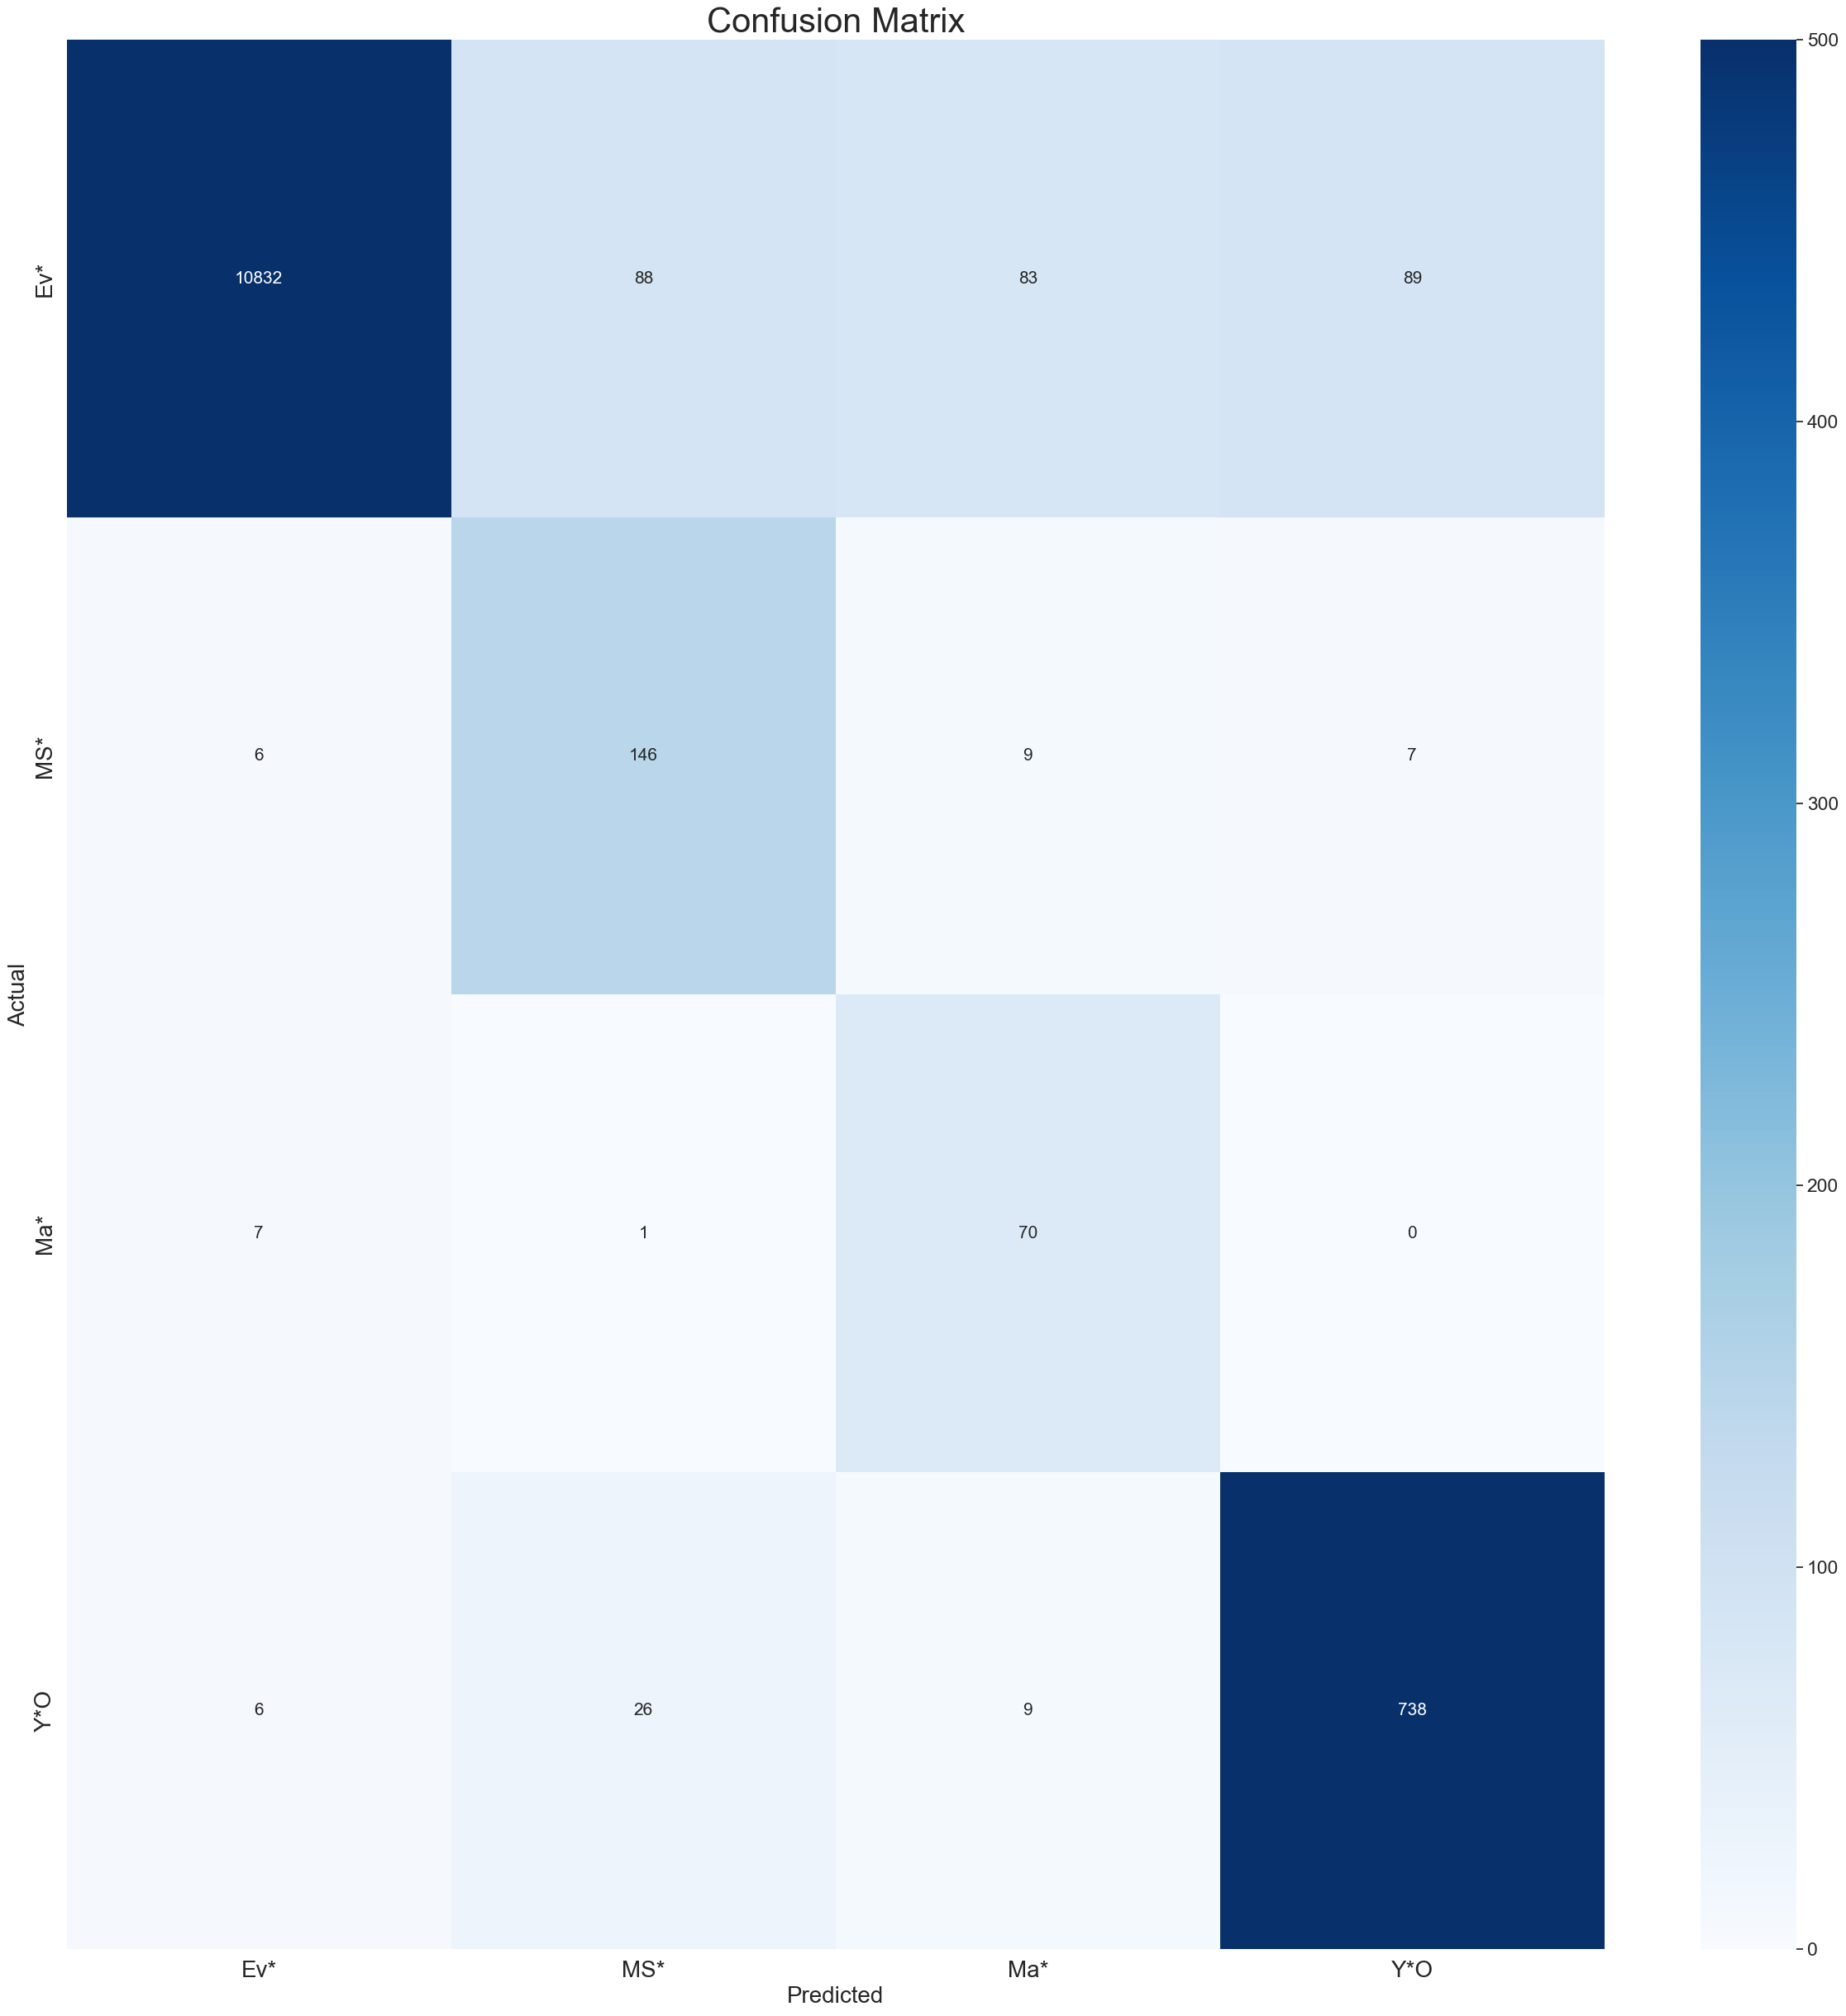

In [10]:
# Load the saved model
model = NeuralNetwork(input_size, output_size).to(device)
model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(y_batch.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.categories_[0][unique_labels])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()